In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import plotly as plt
import pickle
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.metrics import roc_curve, auc, RocCurveDisplay
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from luciferml.supervised.classification import Classification
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import plot_roc_curve
from luciferml.supervised.classification import Classification
from luciferml.preprocessing import Preprocess as prep
from sklearn.pipeline import make_pipeline
from sklearn.metrics import make_scorer
from matplotlib import pylab as plt
from luciferml.supervised.classification import Classification
from luciferml.preprocessing import Preprocess as prep

In [2]:
df = pd.read_excel(r'C:\Users\ASUS Zephyrus G15\DATA1030-Fall2021\data 1030 project\data\전국상수도수질검사표준데이터.xls')

In [3]:
y = df['Potability']
X = df.loc[:, df.columns != 'Potability']

In [4]:
std_ftrs = ['general_bacteria','lead','fluoride','arsenic','selenium','ammonia-like_nitrogen',
            'nitrogen_nitrate','cadmium','phenol','diazinone','carbaryl','1_1_1-trichloroethane','tetrachloroethylene','trichloroethylene',
            'carbon_tetrachloride','1_1-dichloroethylene','dichloromethane','toluene','Xylene','1_2-dibromo-3-chloropropane','1_4-dioxane.','residual_goat',
            'total_trihalomethane','chloroform','bromodichloromethane','chloral_hydrate','dibromoacetonitrile','dichloroacetonitrile','trichloroacetonitrile',
            'haloacetic_seed','formaldehyde','Bronze','chromaticity','detergent','pH','zinc','chloride_ion','Fe','Mn',
            'turbidity','sulfate_ion','potasium_permanganate_consumption','aluminum']

preprocessor = ColumnTransformer(transformers=[('std', StandardScaler(), std_ftrs)])

param_grid= {  
'logisticregression__penalty': ['l1','l2'],'logisticregression__C': np.logspace(-4, 4, 20)
}

test_scores = np.zeros(5)
final_models = []

for i in range(5):
    X_other, X_test, y_other, y_test = train_test_split(X,y,test_size = 0.2,random_state=47*i) # seperate test set and other

    # splitter for other
    kf = KFold(n_splits=5,shuffle=True,random_state=47 * i)

    # the classifier
    clf = LogisticRegression(solver='saga',max_iter=10000,random_state = 47*i) # initialize the classifier
    pipe = make_pipeline(preprocessor,clf)

    # prepare the gridsearch it will loops through all parameter combinations and collects the results 
    
    grid = GridSearchCV(pipe, param_grid=param_grid,scoring = 'accuracy',
                        cv=kf, return_train_score = True, n_jobs=-1, verbose=True)
    
    # fits the model on other
    grid.fit(X_other, y_other)
    
    # save results into a data frame.
    results = pd.DataFrame(grid.cv_results_)
    #print(results)

    print('best model parameters:',grid.best_params_)
    print('validation score:',grid.best_score_) # this is the mean validation score over all iterations
    # save the model
    final_models.append(grid)
    
    # print out and save the test score, baseline accuracy, std 
    y_test_pred = final_models[-1].predict(X_test)
    test_scores[i] = accuracy_score(y_test,y_test_pred)
    print('test score:',test_scores[i])
    print('test baseline = ',np.sum(y_test == 1)/len(y_test))
    print('test accuracy:',np.around(np.mean(test_scores),2),'+/-',np.around(np.std(test_scores),2))
    
    #save the files
    fname = r'C:\Users\ASUS Zephyrus G15\DATA1030-Fall2021\data 1030 project\results\LR'+str(i)+'.lasso'
    file = open(fname, 'wb')
    pickle.dump((grid,X_test,y_test),file)
    file.close()
    

Fitting 5 folds for each of 40 candidates, totalling 200 fits
best model parameters: {'logisticregression__C': 206.913808111479, 'logisticregression__penalty': 'l1'}
validation score: 0.7629108069844267
test score: 0.7622549019607843
test baseline =  0.571078431372549
test accuracy: 0.15 +/- 0.3
Fitting 5 folds for each of 40 candidates, totalling 200 fits
best model parameters: {'logisticregression__C': 4.281332398719396, 'logisticregression__penalty': 'l1'}
validation score: 0.7665785747994337
test score: 0.7524509803921569
test baseline =  0.5833333333333334
test accuracy: 0.3 +/- 0.37
Fitting 5 folds for each of 40 candidates, totalling 200 fits
best model parameters: {'logisticregression__C': 0.615848211066026, 'logisticregression__penalty': 'l1'}
validation score: 0.7604322793770646
test score: 0.7647058823529411
test baseline =  0.6200980392156863
test accuracy: 0.46 +/- 0.37
Fitting 5 folds for each of 40 candidates, totalling 200 fits
best model parameters: {'logisticregressio

### Create Confusion Martix and ROC curve

In [5]:
from sklearn.metrics import confusion_matrix

y_true = y_test
y_preds = y_preds = grid.predict(X_test)
                                         
print(confusion_matrix(y_true,y_preds))

[[102  53]
 [ 38 215]]


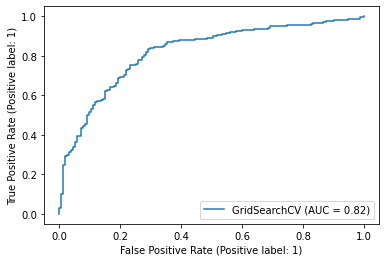

In [6]:
roc = plot_roc_curve(grid, X_test, y_test)
plt.savefig(r'C:\Users\ASUS Zephyrus G15\DATA1030-Fall2021\data 1030 project\figures\LR_ROC_curve.png',dpi = 300)

In [10]:
from sklearn.utils.multiclass import unique_labels

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=True,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = np.array(classes)
    #classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

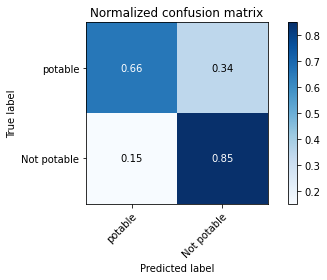

In [12]:
plot_confusion_matrix(y_true,y_preds,classes=['potable','Not potable'])
plt.tight_layout()
plt.savefig(r'C:\Users\ASUS Zephyrus G15\DATA1030-Fall2021\data 1030 project\figures\LR_Confusion_matrix',dpi = 300)
plt.show()

In [13]:
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       0.73      0.66      0.69       155
           1       0.80      0.85      0.83       253

    accuracy                           0.78       408
   macro avg       0.77      0.75      0.76       408
weighted avg       0.77      0.78      0.77       408



In [17]:
np.sqrt(mean_squared_error(y_true,y_preds))

0.47227027821605977

### Semi AutoML version of Parameter tunning did not worked properly

In [37]:
accuracy_scores =  {}


          
██╗░░░░░██╗░░░██╗░█████╗░██╗███████╗███████╗██████╗░░░░░░░███╗░░░███╗██╗░░░░░
██║░░░░░██║░░░██║██╔══██╗██║██╔════╝██╔════╝██╔══██╗░░░░░░████╗░████║██║░░░░░
██║░░░░░██║░░░██║██║░░╚═╝██║█████╗░░█████╗░░██████╔╝█████╗██╔████╔██║██║░░░░░
██║░░░░░██║░░░██║██║░░██╗██║██╔══╝░░██╔══╝░░██╔══██╗╚════╝██║╚██╔╝██║██║░░░░░
███████╗╚██████╔╝╚█████╔╝██║██║░░░░░███████╗██║░░██║░░░░░░██║░╚═╝░██║███████╗
╚══════╝░╚═════╝░░╚════╝░╚═╝╚═╝░░░░░╚══════╝╚═╝░░╚═╝░░░░░░╚═╝░░░░░╚═╝╚══════╝

Started LuciferML 

Checking if labels or features are categorical! [*]

Features are not categorical [ ✓ ]

Labels are not categorical [ ✓ ]

Checking for Categorical Variables Done [ ✓ ]

Checking for Sparse Matrix [*]

Checking for Sparse Matrix Done [ ✓ ]

Applying SMOTE [*]

SMOTE Done [ ✓ ]

Splitting Data into Train and Validation Sets [*]

Splitting Done [ ✓ ]

Scaling Training and Test Sets [*]

Scaling Done [ ✓ ]

Training Logistic Regression on Training Set [*]

Model Training Done [ ✓ ]

Predicting Dat

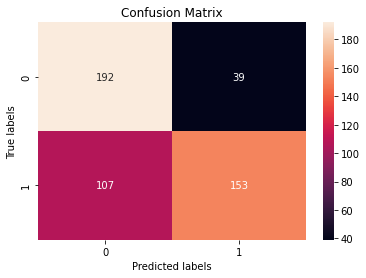

Confusion Matrix Done [ ✓ ]

Evaluating Model Performance [*]
Validation Accuracy is : 0.7026476578411406
Evaluating Model Performance [ ✓ ]

Applying K-Fold Cross Validation [*]
Accuracy: 69.86 %
Standard Deviation: 3.38 %
K-Fold Cross Validation [ ✓ ]

Complete [ ✓ ]

Time Elapsed :  0.24102163314819336 seconds 



In [48]:
params = {'C': 0.00026366508987303583, 'penalty': 'l2', 'solver': 'newton-cg'}

classifier =  Classification(predictor = 'lr',params=params, smote = 'y')
classifier.fit(X, y)
result = classifier.result()
accuracy_scores[result['Classifier']] = result['Accuracy']

In [45]:
accuracy_scores

{'Logistic Regression': 70.27064125142444}